# Matched Filter

This notebook will apply a matched filter to either a single pixel or the average of a selected area for the given datacube `.nc` file.

In [1]:
from spectral import *
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import pickle as pk
import os
from matplotlib import cm

In [2]:
from_path = "processed-data/bedford-capture/capture-2/reflectance/2023_03_14/"

dir_cont = os.listdir(from_path)

data_cubes = [cont for cont in dir_cont if '.nc' in cont]

data_cubes = sorted(data_cubes)

cubes = []

for i in range(len(data_cubes)):    
    # capture every second item for sardi
    # if i%2 == 1:
    #     cubes.append(data_cubes[i])
    cubes.append(data_cubes[i])

print(cubes)

['2023_03_14-02_39_26.nc', '2023_03_14-02_41_27.nc', '2023_03_14-02_42_51.nc', '2023_03_14-02_44_33.nc', '2023_03_14-02_46_28.nc', '2023_03_14-02_49_05.nc', '2023_03_14-02_51_48.nc', '2023_03_14-02_53_36.nc', '2023_03_14-02_56_11.nc', '2023_03_14-02_57_53.nc']


In [3]:
file = "2023_03_14-02_39_26"
path = "evaluations/bedford/spectra/"
base = path + file

In [4]:
# get files for this work
fn = from_path+file+".nc"
png_fn = fn.split('.')[0] + ".png"

In [5]:
# Load data
ds = nc.Dataset(fn)

In [6]:
# extract the datacube from the dataset
dc = np.array(ds['datacube'])

In [7]:
# Data needs to be x, y, bands instead of bands, x, y.
data = dc.transpose(1,2,0)

In [8]:
def process_into_rgb(loc_ds):
    """
    Processes a given dataset into an rgb image for display
    """
    loc_dc = np.array(loc_ds['datacube'])
    loc_binned_wavelengths = np.array(loc_ds['wavelength'])
    loc_image = np.zeros((loc_dc.shape[1],loc_dc.shape[2],3), np.uint8)

    loc_red_wavelength = 620
    loc_green_wavelength = 560
    loc_blue_wavelength = 470

    loc_red_layer = loc_dc[np.argmin(np.abs(loc_binned_wavelengths-loc_red_wavelength)),:,:]  
    loc_green_layer = loc_dc[np.argmin(np.abs(loc_binned_wavelengths-loc_green_wavelength)),:,:] 
    loc_blue_layer = loc_dc[np.argmin(np.abs(loc_binned_wavelengths-loc_blue_wavelength)),:,:] 

    # loc_red_layer = loc_dc[120,:,:]  
    # loc_green_layer = loc_dc[80,:,:] 
    # loc_blue_layer = loc_dc[20,:,:] 

    loc_image[:,:,0] = loc_red_layer
    loc_image[:,:,1] = loc_green_layer
    loc_image[:,:,2] = loc_blue_layer

    # scale the values to within the central 2 to 98 percent values to remove outlier readings
    loc_vmax = np.nanpercentile(loc_image, 98)
    loc_vmin = np.nanpercentile(loc_image, 2)
    loc_image = ((loc_image.astype("f8") - loc_vmin) / (loc_vmax - loc_vmin)).astype("f4")
    loc_image = np.minimum(np.maximum(loc_image, 0), 1)

    loc_image *= 255
    loc_image = loc_image.astype(np.uint8)
    
    return loc_image

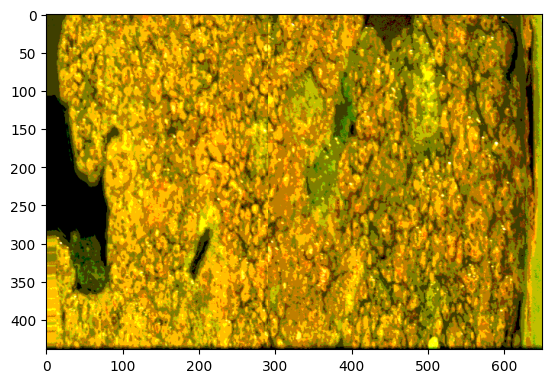

In [9]:
image = process_into_rgb(nc.Dataset(fn.replace('reflectance','radiance')))
plt.imshow(image)

In [10]:
bands = {}

## Spectra Selection

In [46]:
# sample_1
# sample_2
# sample_3
# sample_4

band = 'sample_4'

In [50]:
# let the user select an area to average and match

# Select ROI
r = cv.selectROI("select roi", image)

# close the window
cv.destroyAllWindows()

# Crop hsi image
cropped = dc[:,int(r[1]):int(r[1]+r[3]),int(r[0]):int(r[0]+r[2])]

sample_img = image.copy()
#                         src, startpoint, endpoint, colour, thickness
sample_img = cv.rectangle(sample_img, (int(r[0]),int(r[1])), (int(r[0]+r[2]),int(r[1]+r[3])), (255,27,27), 1)

# take mean of sample area
pixel = np.mean(cropped.reshape(cropped.shape[0], cropped.shape[1]*cropped.shape[2]),1)

In [51]:
# filter the image and match on the chosen pixel
matched = matched_filter(data, pixel)

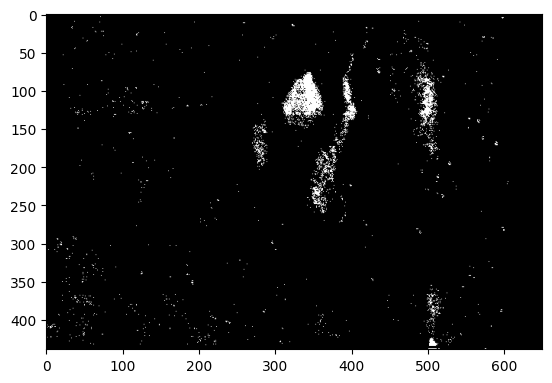

In [52]:
# view the matches from the single pixel
matched_img = 1 * (matched > 0.5)
v = imshow(matched_img)

In [53]:
plt.imsave(base+'_'+band+'_mf.png', matched_img)

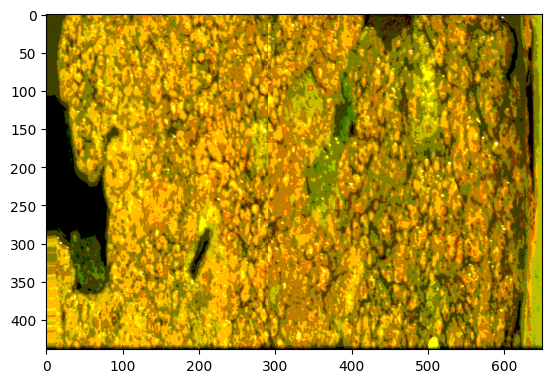

In [54]:
plt.imshow(sample_img)

In [55]:
plt.imsave(base+'_'+band+'_loc.png', sample_img)

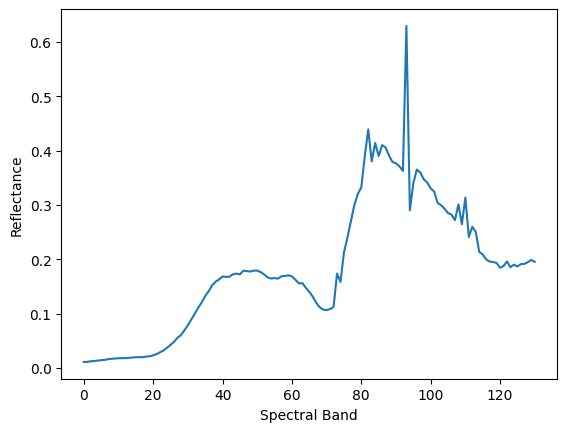

In [56]:
plt.figure()
plt.plot(pixel)
plt.xlabel('Spectral Band')
plt.ylabel('Reflectance')
plt.savefig(base+'_'+band+'.png')
plt.show()

In [57]:
with open(base+'_'+band+'.pkl', 'wb') as out_file:
    pk.dump(pixel, out_file)

In [58]:
bands[band] = pixel

## Combined Plot

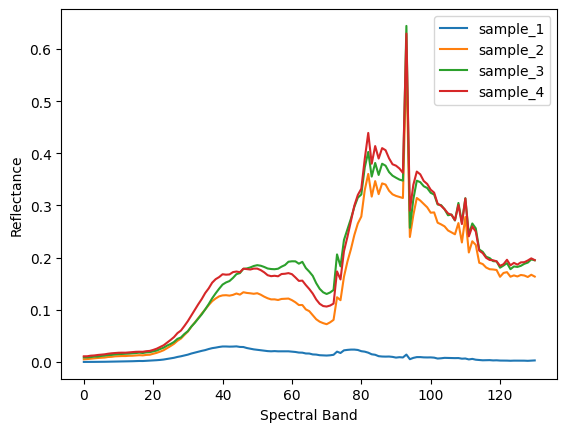

In [62]:
plt.figure()
for name,band in bands.items():
    plt.plot(band, label=name)
plt.xlabel('Spectral Band')
plt.ylabel('Reflectance')
plt.legend()
plt.savefig(base+'_combined.png')
plt.show()

## Comparing across images

In [ ]:
spec_path = "evaluations/sardi/spectra"

dir_cont = os.listdir(spec_path)

dir_pkls = [cont for cont in dir_cont if '.pkl' in cont]

spectra = {}

for i in range(len(dir_pkls)):  
    if 'waste' in dir_pkls[i]:
        print(spec_path+'/'+dir_pkls[i])
        with open(spec_path+'/'+dir_pkls[i], 'rb') as in_file:
            spectra[dir_pkls[i].split('.')[0]]=pk.load(in_file)

In [ ]:
plt.figure()
for name,spec in spectra.items():
    plt.plot(spec, label=name)
plt.xlabel('Spectral Band')
plt.ylabel('Reflectance')
plt.legend()
plt.savefig(spec_path+'/all_waste_comp.png')
plt.show()